In [1]:
from symred.utils import contextualQ
#from openfermion.con import is_contextual
from symred.symplectic import PauliwordOp, random_PauliwordOp, random_symplectic_matrix, StabilizerOp
import numpy as np
import pandas as pd
import time

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

In [37]:
Y_symp = []
Y_para = []
Y_open = []
Y_qisk = []

n_q = 5

for n_t in range(1, 500):
    print(n_t)
    P_symp = random_PauliwordOp(n_q, n_t)
    P_open = sum(P_symp.PauliwordOp_to_OF)
    P_qisk = P_symp.to_PauliSumOp
    
    Y_symp.append(runtime(lambda x:x*x, P_symp, n_samples=5))
    Y_open.append(runtime(lambda x:x*x, P_open, n_samples=5))
    Y_qisk.append(runtime(lambda x:x@x, P_qisk, n_samples=5))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


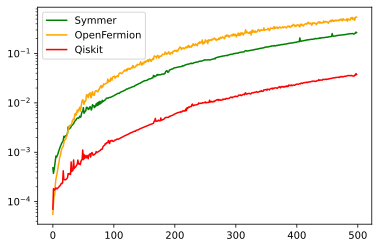

In [43]:
from matplotlib import pyplot as plt

plt.plot(Y_symp, color='green', label='Symmer')
plt.plot(Y_open, color='orange', label='OpenFermion')
plt.plot(Y_qisk, color='red', label='Qiskit')
plt.yscale('log')

plt.legend()

In [44]:
def is_noncontextual(self):
    adjacency_matrix = self.commutes_termwise(self)
    # mask the terms that do not commute universally amongst the operator
    mask_non_universal = np.where(~np.all(adjacency_matrix, axis=1))[0]
    # look only at the unique rows in the masked adjacency matrix -
    # identical rows correspond with operators of the same clique
    unique_commutation_character = np.unique(
        adjacency_matrix[mask_non_universal,:][:,mask_non_universal],
        axis=0
    )
    # if the unique commutation characteristics are disjoint, i.e. no overlapping ones 
    # between rows, the operator is noncontextual - hence we sum over rows and check
    # the resulting vector consists of all ones.
    return np.all(np.count_nonzero(unique_commutation_character, axis=0)==1)

def find_noncontextual(operator):
    # order the operator terms by coefficient magnitude
    check_ops = operator.sort(key='magnitude')
    # initialise as identity with 0 coefficient
    I_symp = np.zeros(2*operator.n_qubits, dtype=int)
    noncontextual_operator = PauliwordOp(I_symp, [0])
    for i in range(check_ops.n_terms):
        if (noncontextual_operator+check_ops[i]).is_noncontextual:
            noncontextual_operator+=check_ops[i]
    return noncontextual_operator

In [45]:
n_qubits = 10

X = []
Y_symp_noncon = []
Y_legacy_noncon = []
Y_symp_random = []
Y_legacy_random = []

for n_terms in range(100):
    print(n_terms)
    X.append(n_terms+1)
    random = random_PauliwordOp(n_qubits,n_terms+1)
    random_list = list(random.to_dictionary.keys())
    noncon = random_PauliwordOp(n_qubits,n_terms, diagonal=True) + random_PauliwordOp(n_qubits,1)
    noncon_list = list(noncon.to_dictionary.keys())
    # contextual operator check
    Y_symp_random.append(runtime(is_noncontextual, random))
    Y_legacy_random.append(runtime(contextualQ, random_list))
    # noncontextual operator check
    Y_symp_noncon.append(runtime(is_noncontextual, noncon))
    Y_legacy_noncon.append(runtime(contextualQ, noncon_list))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


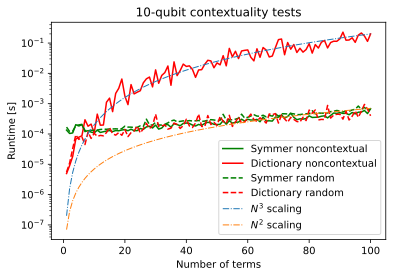

In [47]:
from matplotlib import pyplot as plt

X = np.array(X)

fig, axis = plt.subplots()
# data curves
axis.plot(X, Y_symp_noncon, color='green', label='Symmer noncontextual')
axis.plot(X, Y_legacy_noncon, color='red', label='Dictionary noncontextual')
axis.plot(X, Y_symp_random, color='green', ls='--', label='Symmer random')
axis.plot(X, Y_legacy_random, color='red', ls='--', label='Dictionary random')
# scaling curves
axis.plot(X, 2e-7*np.power(X, 3), label='$N^3$ scaling', ls='-.', lw=1)
axis.plot(X, 7e-8*np.power(X, 2), label='$N^2$ scaling', ls='-.', lw=1)

axis.set_yscale('log')
axis.set_ylabel('Runtime [s]')
axis.set_xlabel('Number of terms')
axis.set_title(f'{n_qubits}-qubit contextuality tests')

axis.legend()
plt.show()

In [187]:
#from openfermion.contextuality import is_contextual